
📊 One-Class SVM
Accuracy : 0.5672268907563025
Precision: 0.5248618784530387
Recall   : 0.8482142857142857
F1-score : 0.6484641638225256

📊 LOF
Accuracy : 0.47058823529411764
Precision: 0.4672897196261682
Recall   : 0.8928571428571429
F1-score : 0.6134969325153374


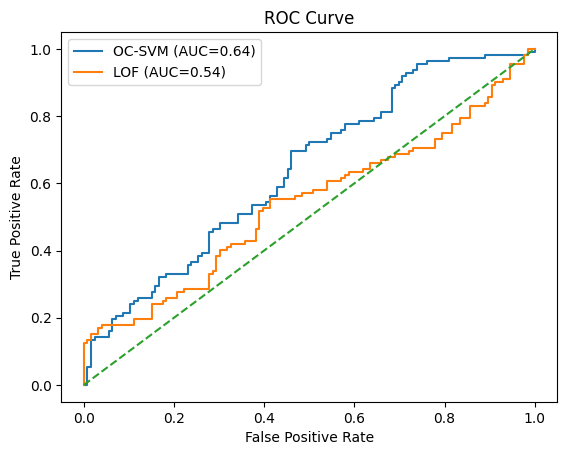

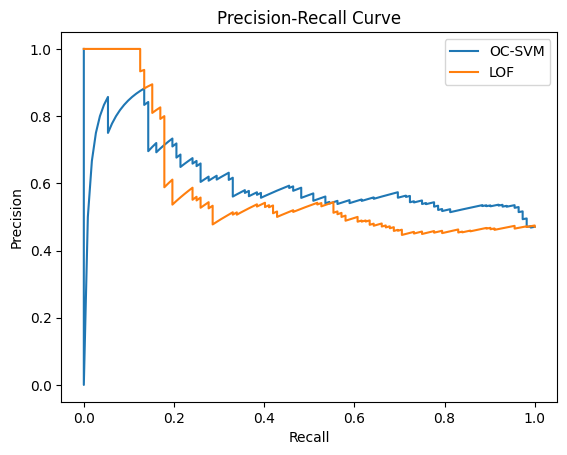

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve
)

import matplotlib.pyplot as plt


# ==============================
# 1️⃣ Chargement du dataset
# ==============================
df = pd.read_csv("Dataset2.csv")

TARGET_COL = "target"   # ⚠️ adapte si nécessaire
NORMAL_CLASS = df[TARGET_COL].unique()[0]  # classe cible (normale)

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# ==============================
# 2️⃣ Standardisation
# ==============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==============================
# 3️⃣ Train / Test split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ==============================
# 4️⃣ Construction du TRAIN anomalie
# ==============================
# Classe normale
X_train_normal = X_train[y_train == NORMAL_CLASS]

# Autres classes (anomalies)
X_train_anomaly = X_train[y_train != NORMAL_CLASS]

# 90% normal
n_normal = int(0.9 * len(X_train_normal))
X_train_normal = X_train_normal[:n_normal]

# 10% anomalies
n_anomaly = int(0.1 * len(X_train_anomaly))
X_train_anomaly = X_train_anomaly[:n_anomaly]

# Dataset final d'entraînement
X_train_final = np.vstack([X_train_normal, X_train_anomaly])

# ==============================
# 5️⃣ Labels binaires pour évaluation
# ==============================
# Normal = 1 | Anomalie = -1
y_test_binary = np.where(y_test == NORMAL_CLASS, 1, -1)

# ==============================
# 6️⃣ ONE-CLASS SVM
# ==============================
ocsvm = OneClassSVM(
    kernel="rbf",
    nu=0.1,
    gamma="scale"
)

ocsvm.fit(X_train_final)

y_pred_ocsvm = ocsvm.predict(X_test)
scores_ocsvm = ocsvm.decision_function(X_test)

# ==============================
# 7️⃣ LOCAL OUTLIER FACTOR (novelty)
# ==============================
lof = LocalOutlierFactor(
    n_neighbors=20,
    novelty=True,
    contamination=0.1
)

lof.fit(X_train_final)

y_pred_lof = lof.predict(X_test)
scores_lof = lof.decision_function(X_test)

# ==============================
# 8️⃣ MÉTRIQUES (4)
# ==============================
def compute_metrics(y_true, y_pred, name):
    print(f"\n📊 {name}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, pos_label=1))
    print("Recall   :", recall_score(y_true, y_pred, pos_label=1))
    print("F1-score :", f1_score(y_true, y_pred, pos_label=1))


compute_metrics(y_test_binary, y_pred_ocsvm, "One-Class SVM")
compute_metrics(y_test_binary, y_pred_lof, "LOF")

# ==============================
# 9️⃣ COURBE ROC
# ==============================
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary, scores_ocsvm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_lof, tpr_lof, _ = roc_curve(y_test_binary, scores_lof)
roc_auc_lof = auc(fpr_lof, tpr_lof)

plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f"OC-SVM (AUC={roc_auc_svm:.2f})")
plt.plot(fpr_lof, tpr_lof, label=f"LOF (AUC={roc_auc_lof:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ==============================
# 🔟 PRECISION-RECALL CURVE
# ==============================
prec_svm, rec_svm, _ = precision_recall_curve(y_test_binary, scores_ocsvm)
prec_lof, rec_lof, _ = precision_recall_curve(y_test_binary, scores_lof)

plt.figure()
plt.plot(rec_svm, prec_svm, label="OC-SVM")
plt.plot(rec_lof, prec_lof, label="LOF")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
